In [17]:
GIT_REPO = '/Users/virgilefoy/Workspace/point_cloud_analysis_and_neural_udfs/'
import sys
sys.path.append(GIT_REPO)

from src.point_cloud_analysis import compute_neighborhoods, compute_pauly_indicator_on_surface, compute_ks_pvalues_on_surface

import trimesh
from trimesh.sample import sample_surface, sample_surface_even

import numpy as np
import matplotlib.pyplot as plt

import scipy
from scipy.spatial.distance import cdist
from scipy.spatial import distance_matrix

from sklearn.preprocessing import MinMaxScaler

import time as T

In [18]:
print('Python ', sys.version)
print('numpy ', np.__version__)
print('trimesh', trimesh.__version__)
import matplotlib
print('matplotlib', matplotlib.__version__)
print('scipy', scipy.__version__)
import sklearn
print('scikit-learn', sklearn.__version__)

Python  3.8.19 | packaged by conda-forge | (default, Mar 20 2024, 12:50:25) 
[Clang 15.0.7 ]
numpy  1.24.4
trimesh 4.4.1
matplotlib 3.7.5
scipy 1.10.1
scikit-learn 1.3.2


In [3]:
def load_mesh(cat, shape_index):
    
    mesh_path = f'/Users/virgilefoy/Dropbox/shapenet_meshes/{cat}s/mesh_{shape_index}.stl'
    mesh = trimesh.load_mesh(mesh_path)
    
    return mesh
    
def sample_surface_and_compute_estimator(mesh, n_s, k, descriptor, t=None):

    points = np.array(sample_surface(mesh, n_s)[0])

    neighborhoods_list = compute_neighborhoods(
        point_cloud=points, 
        method='nn',
        k_neighbors=k
    )

    neighborhood_diameters = [np.max(distance_matrix(points[indices], points[indices]), axis=(0,1)) for indices in neighborhoods_list]
    
    if descriptor == 'ks':
        
        p_values_ks = compute_ks_pvalues_on_surface(points, neighborhoods_list)
        estimator = -np.log10(p_values_ks)  
            
    elif descriptor == 'pauly':
        
        estimator = compute_pauly_indicator_on_surface(points, neighborhoods_list)
        
    if t is not None:
        estimator = 1*(estimator>t)   
    
    return points, estimator

def find_closest_estimator_value(query_points, known_points, estimator):
    distances = cdist(query_points, known_points)
    closest_indices = np.argmin(distances, axis=1)
    output = estimator[closest_indices]
    return output

def rotate_yz_plane(points):
    theta = np.radians(90)  # Convert angle to radians
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)

    # Define the rotation matrix
    Rx = np.array([[1, 0, 0],
                   [0, cos_theta, -sin_theta],
                   [0, sin_theta, cos_theta]])

    # Apply the rotation to the points
    rotated_points = np.dot(points, Rx.T)  # Transpose of Rx is used because we want to rotate column vectors

    return rotated_points

def plot_estimator_on_surface(mesh, points, estimator, n_plot_points, figsize=(5,5), rotate_yz=False, save_to=None):

    plot_points = np.array(sample_surface(mesh, n_plot_points)[0])
    estimator_plot_points = find_closest_estimator_value(plot_points, points, estimator)

    fig = plt.figure(figsize=figsize)

    if rotate_yz:
        plot_points = rotate_yz_plane(plot_points)
        
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(plot_points[:, 0], plot_points[:, 1], plot_points[:, 2], c=estimator_plot_points, cmap='viridis_r', s=1)
    ax.set_xlim(-.4,.4)
    ax.set_ylim(-.4,.4)
    ax.set_zlim(-.4,.4)
    ax.axis('off')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.tight_layout()
    if save_to is not None:
        plt.savefig(save_to)
    plt.show()

## Plot descriptor on single shape

Single shape indicator computation:  0.3  s.


<IPython.core.display.Javascript object>


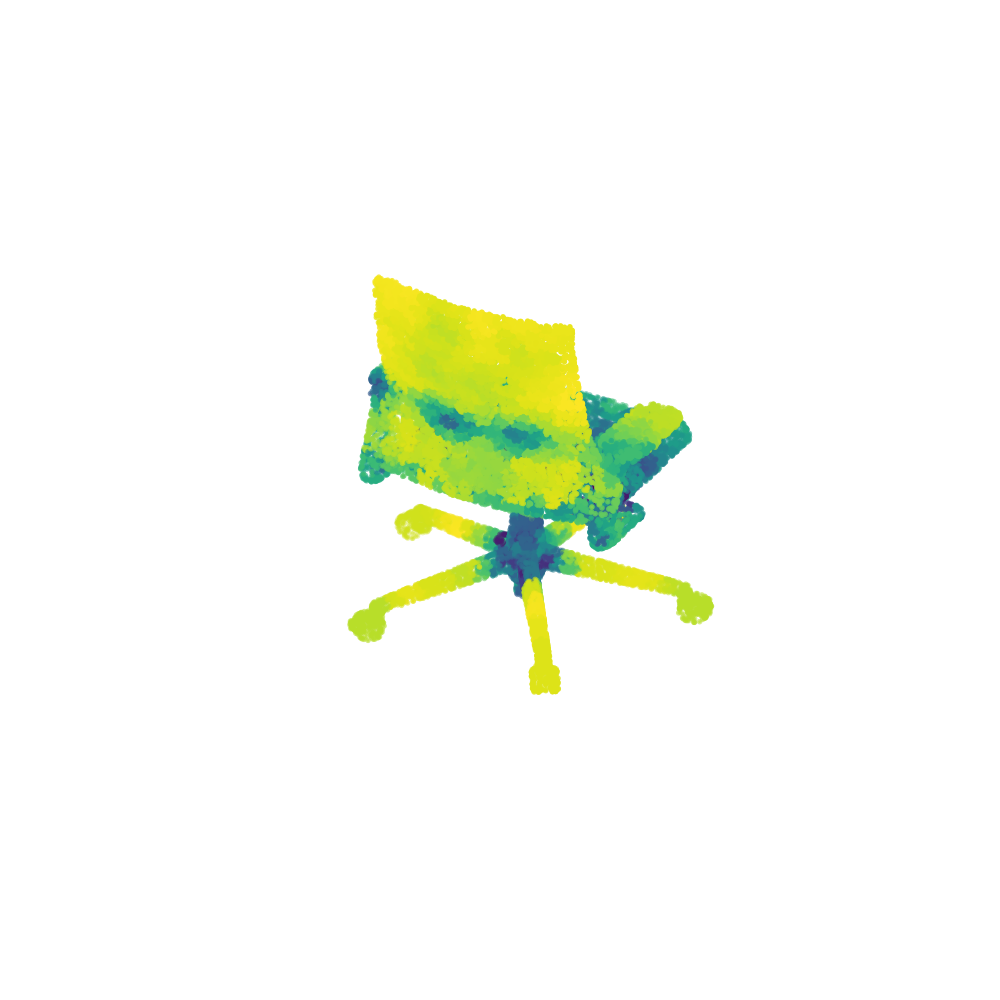

Single plot runtime:  0.5  s.


In [5]:
%matplotlib notebook

cat = 'chair' # chair, car, table, airplanes
shape_index = 7 # <= 99

descriptor = 'pauly' # ks, w

figsize = (10,10)

save_to = None

n_s = 2000
k = 40
t = None

n_plot_points = 30000
rotate_yz=True

mesh = load_mesh(cat, shape_index)

t0=T.time()
points, estimator = sample_surface_and_compute_estimator(mesh, n_s, k, descriptor, t=t)
print('Single shape indicator computation: ', str(np.round(T.time()-t0,1)), ' s.')

t0=T.time()
plot_estimator_on_surface(mesh, points, estimator, n_plot_points, rotate_yz=rotate_yz, figsize=(5,5), save_to=save_to)
print('Single plot runtime: ', str(np.round(T.time()-t0,1)), ' s.')

## Plot mosaic for choice of $k$

In [6]:
def choose_k_mosaic(figsize, k_list, save_to=None):
    
    n_s = 2000
    n_plot_points = 30000
    rotate_yz=True
    
    # Global figure
    fig = plt.figure(figsize=figsize)
    
    for i, cat in enumerate(['chair', 'car', 'table', 'airplane']):
        for j, k in enumerate(k_list):

            mesh = load_mesh(cat, 4)
            
            points, estimator = sample_surface_and_compute_estimator(mesh, n_s, k, 'ks', t=None)
            plot_points = np.array(sample_surface(mesh, n_plot_points)[0])
            estimator_plot_points = find_closest_estimator_value(plot_points, points, estimator)
            plot_points = rotate_yz_plane(plot_points)
            
            ax = fig.add_subplot(4, len(k_list), len(k_list)*i+j+1, projection='3d')
            ax.scatter(plot_points[:, 0], plot_points[:, 1], plot_points[:, 2], c=estimator_plot_points, cmap='viridis_r', s=.5)
            ax.set_xlim(-.3,.3)
            ax.set_ylim(-.3,.3)
            ax.set_zlim(-.3,.3)
            ax.axis('off')
            
            if i == 0:
                ax.set_title(r'$k=$'+str(k), fontsize=25)
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0, wspace=0)
    
    if save_to is not None:
        plt.savefig(save_to, dpi=100)
    
    plt.show()       

<IPython.core.display.Javascript object>


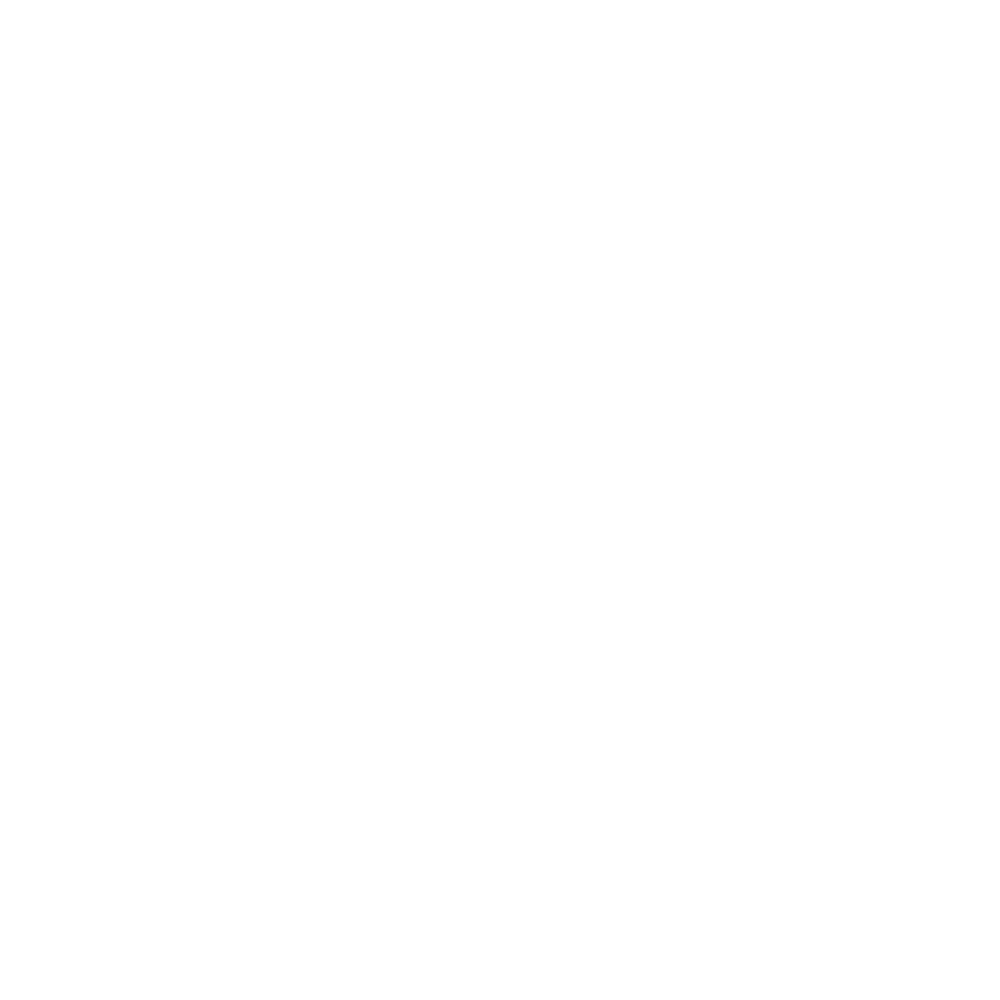

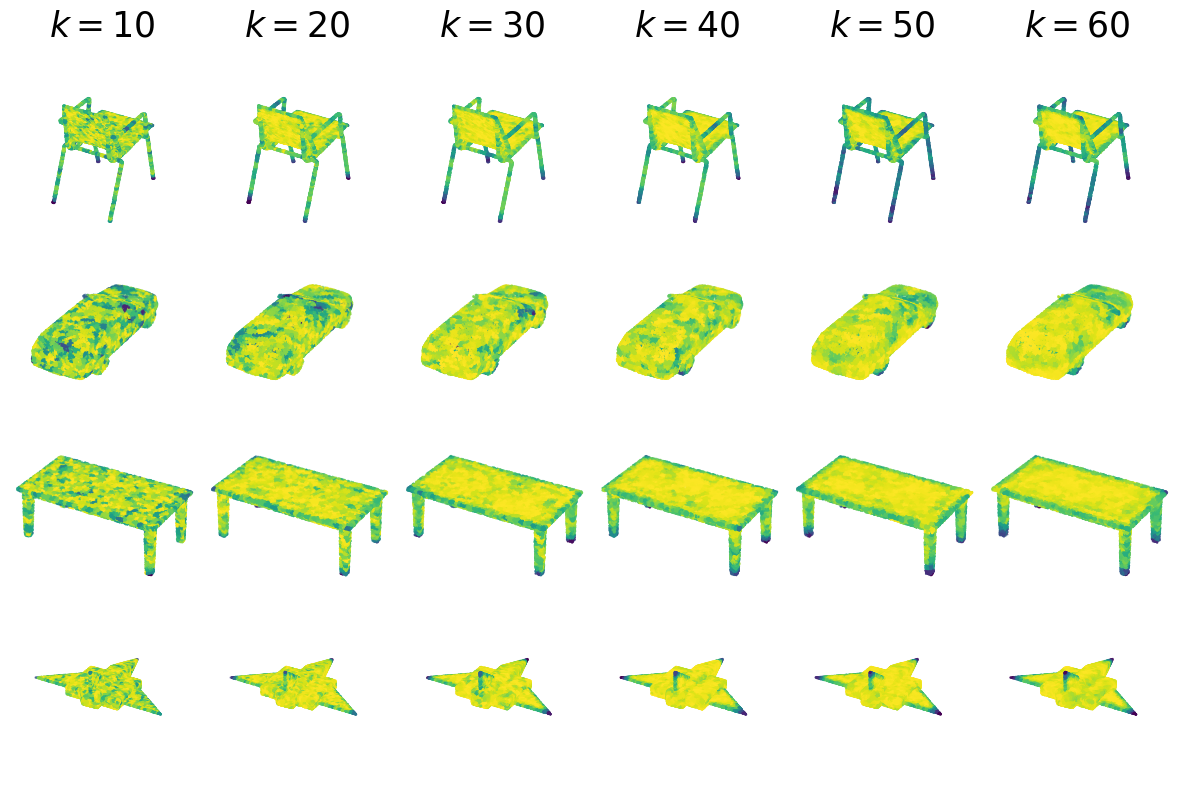

In [7]:
%matplotlib inline
choose_k_mosaic(figsize=(12,8), k_list=[10,20,30,40,50,60], save_to=None)

# Runtime: around 30 seconds...

## Plot mosaic for choice of $t_0$

In [8]:
def choose_t_mosaic(figsize, t_list, save_to=None):
    
    n_s = 2000
    n_plot_points = 30000
    rotate_yz=True
    
    # Global figure
    fig = plt.figure(figsize=figsize)
    
    for i, cat in enumerate(['chair', 'car', 'table', 'airplane']):
        for j, t in enumerate(t_list):

            mesh = load_mesh(cat, 4)
            
            points, estimator = sample_surface_and_compute_estimator(mesh, n_s, 30, 'ks', t=t)
            plot_points = np.array(sample_surface(mesh, n_plot_points)[0])
            estimator_plot_points = find_closest_estimator_value(plot_points, points, estimator)
            plot_points = rotate_yz_plane(plot_points)
            
            ax = fig.add_subplot(4, len(t_list), len(t_list)*i+j+1, projection='3d')
            ax.scatter(plot_points[:, 0], plot_points[:, 1], plot_points[:, 2], c=estimator_plot_points, cmap='viridis_r', s=1)
            ax.set_xlim(-.3,.3)
            ax.set_ylim(-.3,.3)
            ax.set_zlim(-.3,.3)
            ax.axis('off')
            
            if i==0:
                ax.set_title(r'$t_0=$'+str(t), fontsize=25)
            
    plt.tight_layout()
    plt.subplots_adjust(hspace=0, wspace=0)
    
    if save_to is not None:
        plt.savefig(save_to, dpi=100)
    
    plt.show()       

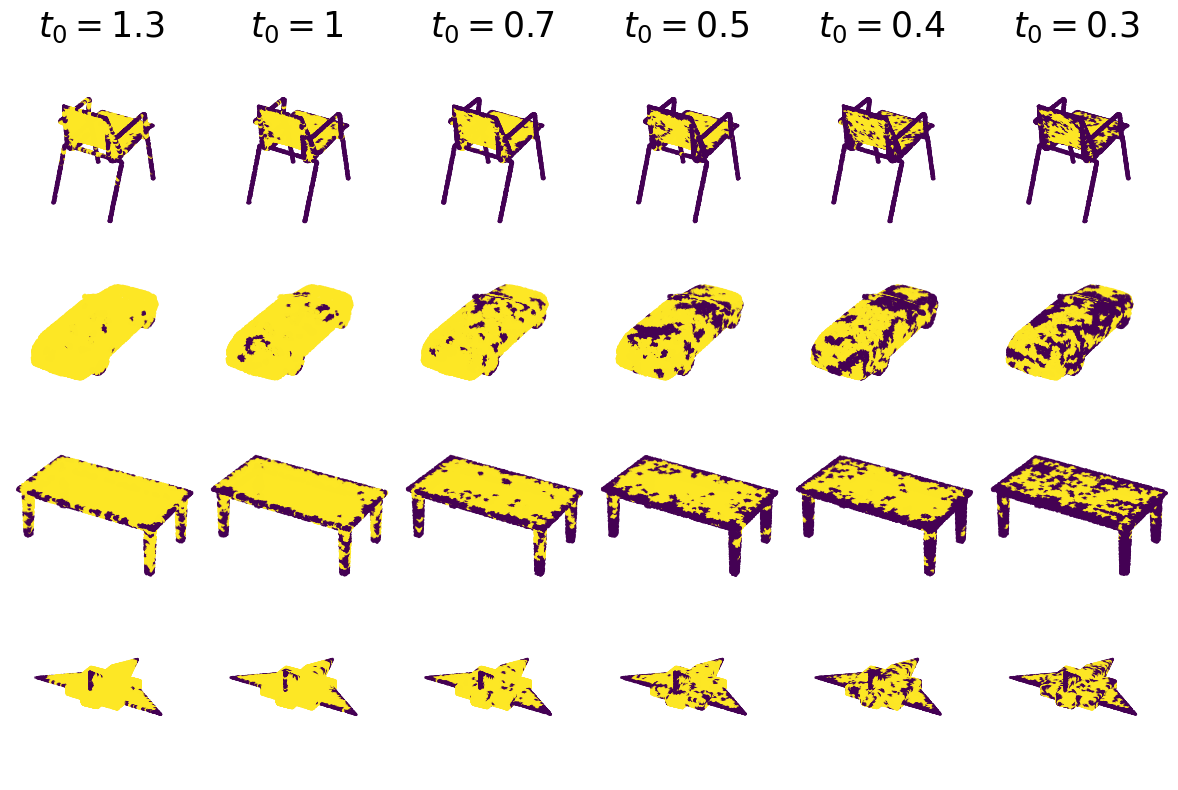

In [9]:
%matplotlib inline
choose_t_mosaic(figsize=(12,8), t_list=[1.3,1,.7,.5,.4,.3], save_to=None) 

# Runtime: around 30 seconds...

## Plot mosaic KS vs. W

In [21]:
def compare_ks_w_mosaic(figsize, n_shapes, save_to=None):
    
    n_s = 2000
    k = 30
    n_plot_points = 30000
    rotate_yz=True
    
    # Global figure
    fig = plt.figure(figsize=figsize)
    
    for i, cat in enumerate(['chair', 'car', 'table', 'airplane']):
        for shape_index in range(n_shapes):

            mesh = load_mesh(cat, shape_index)
            
            points, descriptor = sample_surface_and_compute_estimator(mesh, n_s, k, 'pauly', t=.15)
            plot_points = np.array(sample_surface(mesh, n_plot_points)[0])
            descriptor_plot_points = find_closest_estimator_value(plot_points, points, descriptor)
            plot_points = rotate_yz_plane(plot_points)
            
            ax = fig.add_subplot(8, 8, 16*i+shape_index+1, projection='3d')
            ax.scatter(plot_points[:, 0], plot_points[:, 1], plot_points[:, 2], c=descriptor_plot_points, cmap='viridis_r', s=1)
            ax.set_xlim(-.3,.3)
            ax.set_ylim(-.3,.3)
            ax.set_zlim(-.3,.3)
            ax.axis('off')
            
            points, descriptor = sample_surface_and_compute_estimator(mesh, n_s, k, 'ks', t=.8)
            plot_points = np.array(sample_surface(mesh, n_plot_points)[0])
            descriptor_plot_points = find_closest_estimator_value(plot_points, points, descriptor)
            plot_points = rotate_yz_plane(plot_points)
            
            ax = fig.add_subplot(8, 8, 16*i+8+shape_index+1, projection='3d')
            ax.scatter(plot_points[:, 0], plot_points[:, 1], plot_points[:, 2], c=descriptor_plot_points, cmap='viridis_r', s=1)
            ax.set_xlim(-.3,.3)
            ax.set_ylim(-.3,.3)
            ax.set_zlim(-.3,.3)
            ax.axis('off')
            
    plt.tight_layout()
    plt.subplots_adjust(hspace=0, wspace=0)
    
    if save_to is not None:
        plt.savefig(save_to, dpi=100)
    
    plt.show()       

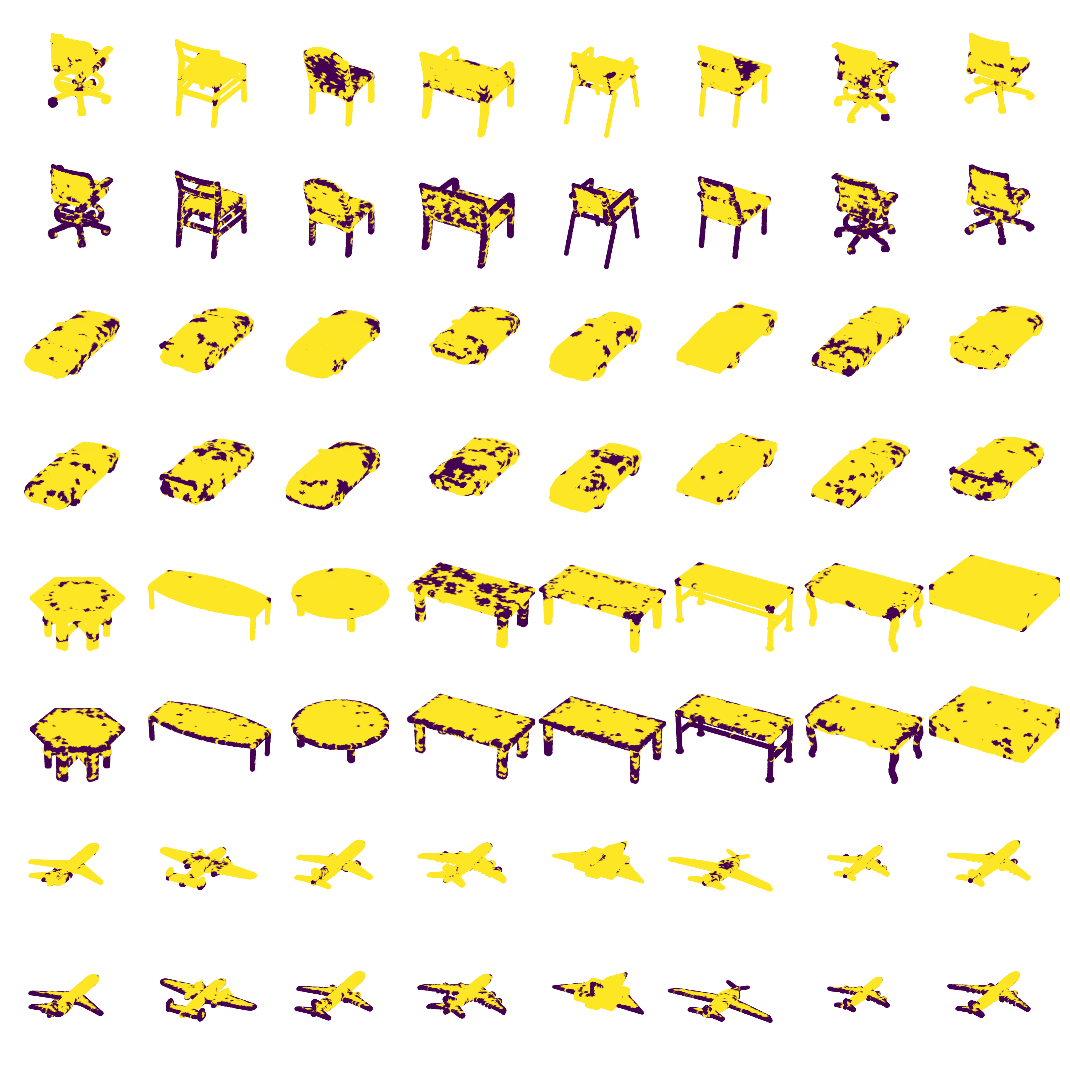

In [22]:
compare_ks_w_mosaic(figsize=(10.8,10.8), n_shapes=8, save_to=None)

# Runtime: around 60 seconds...

## Mosaic short version (more flat)

In [23]:
def compare_ks_w_mosaic_short_version(figsize, n_shapes, cats, save_to=None):
    
    n_s = 2000
    k = 30
    n_plot_points = 30000
    rotate_yz=True
    
    # Global figure
    fig = plt.figure(figsize=figsize)
    
    for i, cat in enumerate(cats):
        for shape_index in range(n_shapes):

            mesh = load_mesh(cat, shape_index)
            
            points, descriptor = sample_surface_and_compute_estimator(mesh, n_s, k, 'pauly', t=.15)
            plot_points = np.array(sample_surface(mesh, n_plot_points)[0])
            descriptor_plot_points = find_closest_estimator_value(plot_points, points, descriptor)
            plot_points = rotate_yz_plane(plot_points)
            
            mult = i if i<=1 else i+2
            ax = fig.add_subplot(len(cats), 2*n_shapes, mult*n_shapes+1 + shape_index, projection='3d')
            ax.scatter(plot_points[:, 0], plot_points[:, 1], plot_points[:, 2], c=descriptor_plot_points, cmap='viridis_r', s=1)
            ax.set_xlim(-.3,.3)
            ax.set_ylim(-.3,.3)
            ax.set_zlim(-.3,.3)
            ax.axis('off')
            
            points, descriptor = sample_surface_and_compute_estimator(mesh, n_s, k, 'ks', t=.8)
            plot_points = np.array(sample_surface(mesh, n_plot_points)[0])
            descriptor_plot_points = find_closest_estimator_value(plot_points, points, descriptor)
            plot_points = rotate_yz_plane(plot_points)
            
            mult = i+2 if i<=1 else i+4
            ax = fig.add_subplot(len(cats), 2*n_shapes, mult*n_shapes+1 + shape_index, projection='3d')
            ax.scatter(plot_points[:, 0], plot_points[:, 1], plot_points[:, 2], c=descriptor_plot_points, cmap='viridis_r', s=1)
            ax.set_xlim(-.3,.3)
            ax.set_ylim(-.3,.3)
            ax.set_zlim(-.3,.3)
            ax.axis('off')
            
    plt.tight_layout()
    plt.subplots_adjust(hspace=0, wspace=0)
    
    if save_to is not None:
        plt.savefig(save_to, dpi=100)
    
    plt.show()       

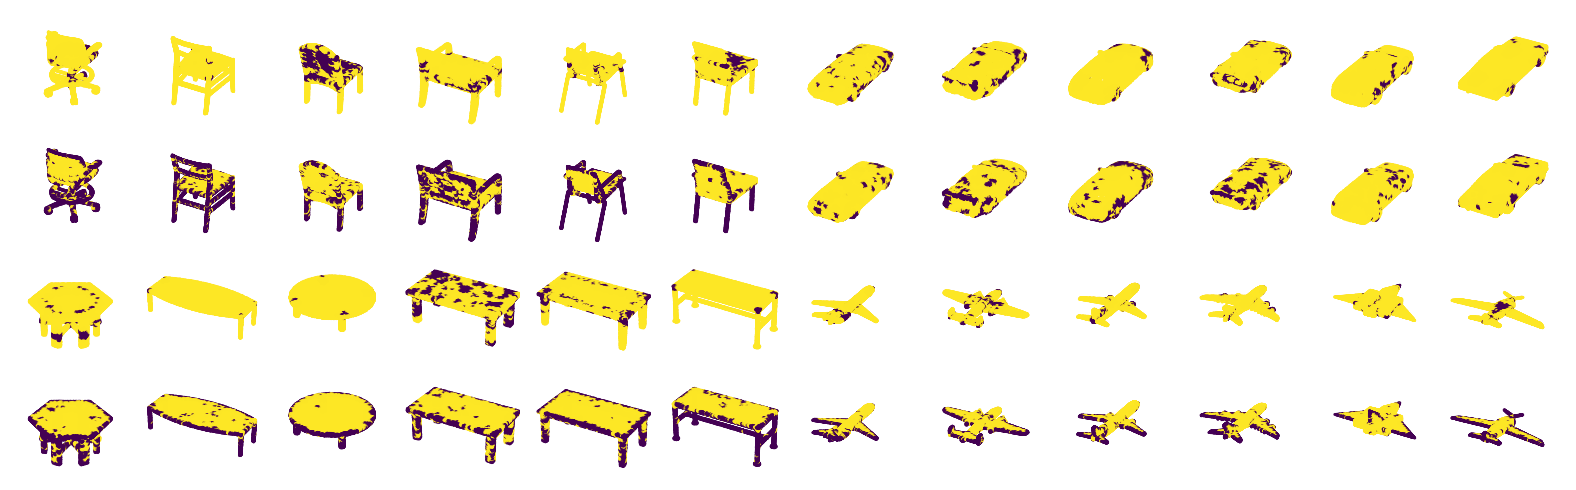

In [24]:
cats = ['chair', 'car', 'table', 'airplane']
compare_ks_w_mosaic_short_version(figsize=(16,5), n_shapes=6, cats=cats, save_to=None)